# Hate Speech Detector

Hate speech proliferates online, posing significant societal challenges and threatening the safety and well-being of individuals and communities. Despite efforts to combat this issue, hate speech often goes undetected due to its complex and evolving nature. Identifying and addressing instances of hate speech is crucial for fostering inclusivity, tolerance, and safety in online spaces.

To curb the effect of hate speech, we will build a machine leaning model that can accuratey identify tweets that are hate speech and be able to filter it out.

## Dataset

The data for this project is obtained from 6 different sources. We download the dataset from each of the sources, merge them and thereafter preprocess it to solve any quality and structural issue with the data.

The process of getting the dataset together are explained below

In [1]:
# Import the libraries
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize


from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

## Dataset one


The first dataset is obtained from this [link](https://github.com/Vicomtech/hate-speech-dataset). We first downloaded it to our local machine and save it in a directory called hate-speech-dataset. The dataset is not structured as it saves each of the tweet in an individual txt file. The corresponding label for the tweet are saved in another folder called annotations_metadata.

The tweet with label are for training while those without label are for testing. We will load the data in all_files folder which contains both training and test data. Thereafter, we will merge it with the label. The resulting dataset will then be separated to train and test base on the presence or absence of label.

In [ ]:
# Specify the path to the folder containing the files
folder_path = "hate-speech-dataset/all_files"

# Use glob to get the list of file names that end with .txt in the folder
file_names = glob.glob(folder_path + "\*.txt")

[]

In [ ]:
# read the content of each files and save the tweet to the corresponding tweet_id

tweet_list = []

for file_name in file_names:
    file_id = file_name.split("\\")[-1][:-4]
    with open(file_name, "r", encoding = "utf-8") as f:
        tweet = f.read()
    tweet_list.append({"file_id": file_id,
                       "tweet": tweet})
# save the first dataset as df1
df1 = pd.DataFrame(tweet_list)
df1.head()

""


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
#get the label for df1 and merge it

df1_label = pd.read_csv("hate-speech-dataset/annotations_metadata.csv")

# merge df1 and df1_label on file_id column

df1 = pd.merge(left = df1, right = df1_label, on  = "file_id", how = "left")

# view the complete dataset
df1.head()

,file_id,tweet,user_id,subforum_id,num_contexts,label
0,12834217_1,"As of March 13th , 2014 , the booklet had been...",572066,1346,0,noHate
1,12834217_10,Thank you in advance. : ) Download the youtube...,572066,1346,0,noHate
2,12834217_2,In order to help increase the booklets downloa...,572066,1346,0,noHate
3,12834217_3,( Simply copy and paste the following text int...,572066,1346,0,noHate
4,12834217_4,Click below for a FREE download of a colorfull...,572066,1346,0,hate


In [ ]:
# We need only the tweet colunms and the label columns

df1 = df1[["tweet", "label"]]

# write a function to cateorize the label
def is_hate(x):
    if x.lower() == "hate":
        return 1
    elif x.lower() == "nohate":
        return 0
    else:
        pass
# create is_hate column
df1["is_hate"] = df1["label"].copy().apply(is_hate)

# drop label column
df1.drop(columns = "label", inplace = True)

df1.head()

,tweet,is_hate
0,"As of March 13th , 2014 , the booklet had been...",0.0
1,Thank you in advance. : ) Download the youtube...,0.0
2,In order to help increase the booklets downloa...,0.0
3,( Simply copy and paste the following text int...,0.0
4,Click below for a FREE download of a colorfull...,1.0


### Dataset 2

The second dataset is gotten from Huggingface. You can access it through this [link](https://huggingface.co/datasets/tweets_hate_speech_detection). The data set is split into train and test. We will merge the two together and rename it to a form that will be consistent with that of df1

In [ ]:
# load train dataset
df2_train = pd.read_csv("huggingface/train_tweet.csv", encoding = "utf-8")
df2_test = pd.read_csv("huggingface/test_tweets.csv", encoding = "utf-8")



In [ ]:
df2_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [ ]:
df2_test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [ ]:
# concat the two datasets

df2 = pd.concat([df2_train, df2_test])

# take out label and tweet columns and thereafter rename label to is_hate
df2 = df2[["tweet", "label"]]

# rename the columns
df2.columns = ["tweet", 'is_hate']

df2.head()

,tweet,is_hate
0,@user when a father is dysfunctional and is s...,0.0
1,@user @user thanks for #lyft credit i can't us...,0.0
2,bihday your majesty,0.0
3,#model i love u take with u all the time in ...,0.0
4,factsguide: society now #motivation,0.0


### Dataset three

The third dataset is called hatespeech kenya. It is obtained from this [link](https://www.kaggle.com/datasets/edwardombui/hatespeech-kenya). We will load the dataset and rename the columns to be consistent with the previous two

In [ ]:
# load the dataset
df3 = pd.read_csv("HateSpeech_Kenya.csv", encoding = "utf-8")
df3.head()

,hate_speech,offensive_language,neither,Class,Tweet
0,0,0,3,0,['The political elite are in desperation. Ordi...
1,0,0,3,0,"[""Am just curious the only people who are call..."
2,0,0,3,0,['USERNAME_3 the area politicians are the one ...
3,0,0,3,0,['War expected in Nakuru if something is not d...
4,0,0,3,0,['USERNAME_4 tells kikuyus activists that they...


In [ ]:
df3['Class'].unique()

array([0, 1, 2], dtype=int64)

0 for Neither; 1 for Offensive; 2 for Hate speech. Therefore we will reclass the label with 1 for hate speech and 0 for other classes.

In [ ]:
# define a function to reasign the label
def reassign_label(x):
    if x == 2:
        return 1
    else:
        return 0

# apply the function on class column
df3['is_hate'] = df3['Class'].apply(reassign_label)
df3.head()

,hate_speech,offensive_language,neither,Class,Tweet,is_hate
0,0,0,3,0,['The political elite are in desperation. Ordi...,0
1,0,0,3,0,"[""Am just curious the only people who are call...",0
2,0,0,3,0,['USERNAME_3 the area politicians are the one ...,0
3,0,0,3,0,['War expected in Nakuru if something is not d...,0
4,0,0,3,0,['USERNAME_4 tells kikuyus activists that they...,0


In [ ]:
# take the tweet and is_hate columns

df3 = df3[["Tweet", "is_hate"]]

# rename the columns to tweet and is_hate
df3.columns = ["tweet", "is_hate"]

In [ ]:
df3.head()

,tweet,is_hate
0,['The political elite are in desperation. Ordi...,0
1,"[""Am just curious the only people who are call...",0
2,['USERNAME_3 the area politicians are the one ...,0
3,['War expected in Nakuru if something is not d...,0
4,['USERNAME_4 tells kikuyus activists that they...,0


### Dataset four


The fourth dataset is Hate Speech Detection curated Dataset gotten from this [link](https://www.kaggle.com/datasets/waalbannyantudre/hate-speech-detection-curated-dataset). we will load the dataset and reconcile the column title

In [ ]:
df4 = pd.read_csv("HateSpeechDataset.csv", encoding = "utf-8")

df4.head()

,Content,Label,Content_int
0,denial of normal the con be asked to comment o...,1,"[146715, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,..."
1,just by being able to tweet this insufferable ...,1,"[146715, 14, 15, 16, 17, 7, 18, 19, 20, 21, 22..."
2,that is retarded you too cute to be single tha...,1,"[146715, 28, 29, 30, 26, 31, 32, 7, 5, 33, 28,..."
3,thought of a real badass mongol style declarat...,1,"[146715, 35, 1, 24, 36, 37, 38, 39, 40, 1, 41,..."
4,afro american basho,1,"[146715, 46, 47, 48, 146714]"


In [ ]:
# get the content and the label columns and rename them to tweet and is_hate respectively\
df4 = df4[["Content", "Label"]]

# rename the columns
df4.columns = ["tweet", "is_hate"]

# view the dataset
df4.head()

,tweet,is_hate
0,denial of normal the con be asked to comment o...,1
1,just by being able to tweet this insufferable ...,1
2,that is retarded you too cute to be single tha...,1
3,thought of a real badass mongol style declarat...,1
4,afro american basho,1


In [ ]:
df4['is_hate'].value_counts()

is_hate
0        361594
1         79305
Label         7
Name: count, dtype: int64

In [ ]:
df4[df4['is_hate'] == "Label"]

,tweet,is_hate
190108,content,Label
418486,content,Label
422333,content,Label
424241,content,Label
426162,content,Label
435474,content,Label
437104,content,Label


seven of the observations in the dataset four has a non boolean label "Label". A closer observations shows that the those entries doesn't make any sense as their correscponding tweet are just "Content". Thus, we will drop those observations

In [ ]:
df4 = df4[df4['is_hate'] != "Label"]

### Dataset five

The fifth dataset is Hate Speech and Offensive Language Dataset from this [link](https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset). Load the dataset and reconcile the columns

In [ ]:
# load the dataset
df5 = pd.read_csv("labeled_data.csv", encoding = "utf-8")

df5.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
df5['class'].unique()

array([2, 1, 0], dtype=int64)

Class 0 refers to hate speech, class 1 refers to offensive language and class 2 refers to neither. We will reclass the label and give those that are hate speech a label of 1 while the other classes are given a label of 0.

In [ ]:
# define a function to reasign the label
def reassign_label(x):
    if x == 0:
        return 1
    else:
        return 0

# apply the function on class column
df5['is_hate'] = df5['class'].apply(reassign_label)
df5.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,is_hate
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,0
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,0
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,0
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,0
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,0


In [ ]:
# ectract the tweet and is_hate columns
df5 = df5[["tweet", "is_hate"]]

df5.head()

,tweet,is_hate
0,!!! RT @mayasolovely: As a woman you shouldn't...,0
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,0
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,0
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,0
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,0


### Complete dataset

Now that each of the datasets have been prepared, we will concat all of them together and do data preprocessing

In [ ]:
# concat df1, df2, df3, df4 and df5

df = pd.concat([df1, df2, df3, df4, df5])

df.head()

,tweet,is_hate
0,"As of March 13th , 2014 , the booklet had been...",0.0
1,Thank you in advance. : ) Download the youtube...,0.0
2,In order to help increase the booklets downloa...,0.0
3,( Simply copy and paste the following text int...,0.0
4,Click below for a FREE download of a colorfull...,1.0


In [ ]:
# Convert the labels to the same datatype
df['is_hate'] = df['is_hate'].astype(float)

In [ ]:
df['is_hate'].unique()

array([ 0.,  1., nan])

## Check for duplicate

Since we gathered the data from different sources, there is possibility of overlap between them. To solve this problem, we check for duplicate entries and then drop them

In [ ]:
# check for duplicates
df.duplicated().sum()

26187

In [ ]:
# Drop duplicate
df.drop_duplicates(inplace = True)

# confirm there is no duplicate again
df.duplicated().sum()

0

## Split to train test

Entries with labels are for training while entries with no label are for testing. Therefore we will split our dataset into train and test base on their corresponding labels

In [ ]:
# Extract Train dataset
df_train = df[df['is_hate'].notnull()]

In [ ]:
# extract test dataset
df_test = df[df['is_hate'].isnull()]

## Save clean dataset

Now we will save the clean dataset

In [ ]:
df_train.to_csv("dataset/clean_train.csv", index = False)
df_test.to_csv("dataset/clean_test.csv", index = False)

## Pre-processing/ EDA

The purpose of this section is to understand and gain insights from the data before using it for modeling. It will help us understand the data better and identify quality issues, e.g., missing values and inconsistencies.

**Load the dataset** \
Here we load the cleaned data set so that we can start our preprocessing.

In [2]:
pip install rarfile

In [4]:
import rarfile

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
rar_path = '/content/drive/MyDrive/Hate-Speech-Detector-Alfred/Hate-Speech-Detector-Jacinta/dataset.rar'

# Open the .rar file
with rarfile.RarFile(rar_path, 'r') as rf:
    # Extract all files to the current directory
    rf.extractall()

In [7]:
# Load the train dataset into a DataFrame
train_df = pd.read_csv('dataset/clean_train.csv')

# View the head of the train dataset
train_df.head(10)

,tweet,is_hate
0,"As of March 13th , 2014 , the booklet had been...",0.0
1,Thank you in advance. : ) Download the youtube...,0.0
2,In order to help increase the booklets downloa...,0.0
3,( Simply copy and paste the following text int...,0.0
4,Click below for a FREE download of a colorfull...,1.0
5,Click on the `` DOWNLOAD ( 7.42 MB ) '' green ...,0.0
6,"Booklet updated on Feb. 14th , 2014 .",0.0
7,"( Now with over 18,300 Downloads. )",0.0
8,PDF file : http://www.mediafire.com/download/7...,0.0
9,Then why not simply copy this text ( & links )...,0.0


In [8]:
#load and view the head of the test dataset
test_df = pd.read_csv('dataset/clean_test.csv')
test_df.head()

,tweet,is_hate
0,"A becsület napjás videó nagyon tuti , mindig a...",NaN
1,Egyet se ismerek .,NaN
2,Fogalmam sincs hogy mennyi lehet itt .,NaN
3,"Itt a legtobb Kanadai anti-rasszista , aki meg...",NaN
4,"A feher embernek nincs jovoje Kanadaba , az bi...",NaN


In [9]:
print(f'The shape of the train dataset: {train_df.shape}')
print(f'The shape of the test dataset: {test_df.shape}')

The shape of the train dataset: (531315, 2)
The shape of the test dataset: (16359, 2)


In [10]:
print("train dataset")
display(train_df.isnull().sum())

print("test dataset")
display(test_df.isnull().sum())

train dataset


tweet      0
is_hate    0
dtype: int64

test dataset


tweet          0
is_hate    16359
dtype: int64

The train dataset has 531315 rows and two columns while the test dataset has 16359 rows and 2 columns. However, the second column of the test datasets has null values since it does not have labels as expected.

In [11]:
#check the unique labels
train_df['is_hate'].unique()

array([0., 1.])

The dataset has two unique values 0 and 1 in the 'is_hate' column which are defined as follows; \
**0**: denotes text that has been classified as non-hate speech \
**1**: denotes a text that has been classified as hate speech


## Distribution of the Labels
*  Below are a Bar Plot and a Pie Chart to illustrate the count of texts under each label in the train dataset.


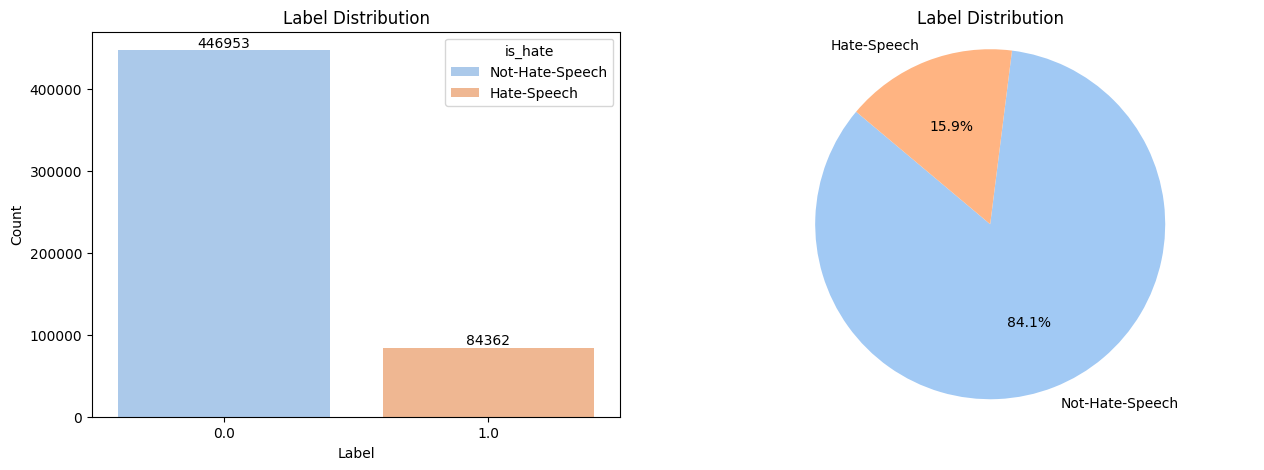

In [12]:
# Count the number of occurrences of each unique label
label_counts = train_df['is_hate'].value_counts()

# Rename labels
label_mapping = {1: 'Hate-Speech', 0: 'Not-Hate-Speech'}

# Set up the subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
sns.countplot(x='is_hate', data=train_df, palette='pastel', ax=axes[0], hue=train_df['is_hate'].map(label_mapping))
axes[0].set_title('Label Distribution')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')

# Add labels to bars
for index, value in enumerate(label_counts):
    axes[0].text(index, value, str(value), ha='center', va='bottom')

# Pie chart
axes[1].pie(label_counts, labels=label_counts.index.map(label_mapping), autopct='%1.1f%%', colors=sns.color_palette('pastel'), startangle=140)
axes[1].set_title('Label Distribution')

# Equal aspect ratio ensures that pie is drawn as a circle.
axes[1].axis('equal')

plt.show()


##Wordcloud
Visualising the texts to see the most frequent used words in relation to hate speech

In [13]:
from wordcloud import WordCloud

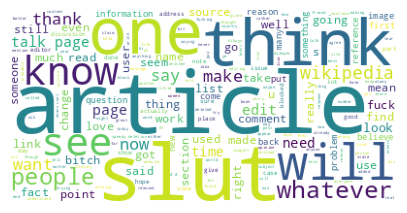

In [14]:
full_text = " ".join(train_df['tweet'])
wc = WordCloud(background_color='white')
img = wc.generate(full_text)
plt.figure(figsize= (5,5))
plt.imshow(img)
plt.axis('off')
plt.show()

**Tweet WordCloud for Each Classification of Tweets**

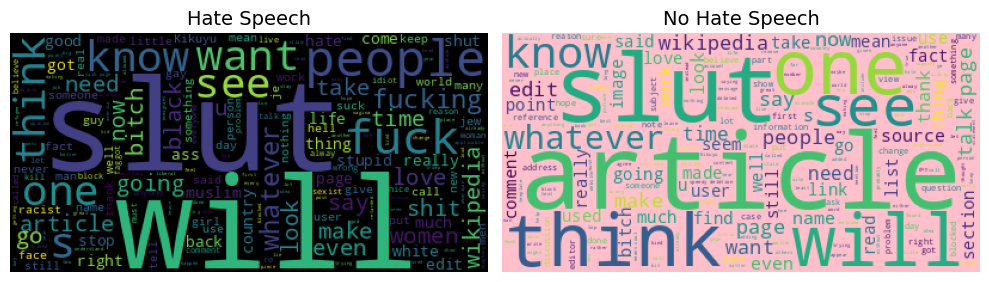

In [15]:
# First word cloud
class_df = train_df.groupby('is_hate')
hate_speech = "".join(class_df.get_group(1.0)['tweet'])
wc1 = WordCloud(background_color='black')
img1 = wc1.generate(hate_speech)
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
plt.subplot(1, 2, 1)  # Subplot 1
plt.imshow(img1)
plt.axis('off')
plt.title('Hate Speech', fontsize=14)

# Second word cloud
no_hate_speech = "".join(class_df.get_group(0.0)['tweet'])
wc2 = WordCloud(background_color='pink')
img2 = wc2.generate(no_hate_speech)
plt.subplot(1, 2, 2)  # Subplot 2
plt.imshow(img2)
plt.axis('off')
plt.title('No Hate Speech', fontsize=14)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


From the wordcloud above, it is observed that offensive words or slangs like **slut, fucking, shit, bitch, faggot, black, racist, and suck** are commonly used unlike the nonhate speech category. Now, we will clean the text using the outline below:

## **Text Cleaning**:
In this section, we will perform the following:
* remove any unnecessary characters or formatting from the text data, such as punctuation marks, stopwords, and URLs.
* Put all text in lowercase
* Stemming
* Downsampling or upsampling the dataset.

### Removing URLs

In [16]:
train_copy = train_df.copy()
# Function to check for URLs in a given text
def contains_url(text):
    url_pattern = r'https?://\S+'
    return bool(re.search(url_pattern, text))

# Apply the function to each row of the 'tweet' column
train_copy['contains_url'] = train_copy['tweet'].apply(contains_url)

# Filter rows where URL is present
tweets_with_url = train_copy[train_copy['contains_url'] == True]

# Display the tweets with URLs
print(tweets_with_url[['tweet', 'is_hate']])


                                                    tweet  is_hate
1       Thank you in advance. : ) Download the youtube...      0.0
8       PDF file : http://www.mediafire.com/download/7...      0.0
14      PDF file : http://www.mediafire.com/download/4...      0.0
15      Thank you in advance. : ) Download the youtube...      0.0
188     It can be read online here : http://www.rastko...      0.0
...                                                   ...      ...
531216  when you first walked in the door at that part...      0.0
531258  wth is that playing missy? ........ i mean ser...      0.0
531276    yeah I'm small den a hoe http://t.co/VV3qdTo7MG      0.0
531298  you gotta be a new breed of retarded if you do...      0.0
531314  ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...      0.0

[3195 rows x 2 columns]


The dataset contains URLS. These URLs wil be replaced with a placeholder string ("url") to preserve the structure of the text while removing potentially irrelevant information.

In [17]:
train_copy.head()

,tweet,is_hate,contains_url
0,"As of March 13th , 2014 , the booklet had been...",0.0,False
1,Thank you in advance. : ) Download the youtube...,0.0,True
2,In order to help increase the booklets downloa...,0.0,False
3,( Simply copy and paste the following text int...,0.0,False
4,Click below for a FREE download of a colorfull...,1.0,False


In [18]:
# Drop the 'contains_url' column from the DataFrame
train_copy.drop(columns=['contains_url'], inplace=True)

# Display the updated DataFrame
print(train_copy.head())

                                               tweet  is_hate
0  As of March 13th , 2014 , the booklet had been...      0.0
1  Thank you in advance. : ) Download the youtube...      0.0
2  In order to help increase the booklets downloa...      0.0
3  ( Simply copy and paste the following text int...      0.0
4  Click below for a FREE download of a colorfull...      1.0


In [19]:
# Function to replace URLs with 'url' placeholder
def replace_urls(text):
    url_pattern = r'https?://\S+'
    return re.sub(url_pattern, 'url', text)

# Replace URLs in the 'tweet' column of the DataFrame
train_copy['tweet'] = train_copy['tweet'].apply(replace_urls)

# Display the updated DataFrame
print(train_copy.head())


                                               tweet  is_hate
0  As of March 13th , 2014 , the booklet had been...      0.0
1  Thank you in advance. : ) Download the youtube...      0.0
2  In order to help increase the booklets downloa...      0.0
3  ( Simply copy and paste the following text int...      0.0
4  Click below for a FREE download of a colorfull...      1.0


In [20]:
# confirm the links are removed
train_copy['tweet'][8]

"PDF file : url _ 2-14-14.docx Watch the 10 hour video version of `` The Zionist Attack on Western Civilization '' @ url _ White _ YT _ Comment _ ( Hyperlinked ) .txt url ( Hyperlinked-Back-Up % 5D.txt url ? v = _ 8hg254ALpM Are you interested in helping spread the booklet download link across the world ?"

### Removing stopwords, punctuations, and converting all text to lowercase

In [21]:
# Download stopwords
nltk.download('stopwords')

# Define stopwords
stop_words = set(stopwords.words('english'))

# Function to clean text
def clean_text(text):
    # Remove punctuation using regular expression
    cleaned_text = re.sub(r"([^A-Za-z\s]+)", '', text)

    # Convert text to lowercase
    cleaned_text = cleaned_text.lower()

    # Remove stopwords
    cleaned_text = ' '.join(word for word in cleaned_text.split() if word not in stop_words)

    return cleaned_text

# Apply the clean_text function to the 'tweet' column
train_copy['tweet'] = train_copy['tweet'].apply(clean_text)

# Display the updated DataFrame
print(train_copy.head(10))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                                               tweet  is_hate
0         march th booklet downloaded times counting      0.0
1  thank advance download youtube description box...      0.0
2  order help increase booklets downloads would g...      0.0
3  simply copy paste following text youtube video...      0.0
4  click free download colorfully illustrated pag...      1.0
5                click download mb green banner link      0.0
6                             booklet updated feb th      0.0
7                                          downloads      0.0
8  pdf file url docx watch hour video version zio...      0.0
9  simply copy text links paste description box y...      0.0


### Stemming


In [22]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

# Download 'punkt' tokenizer
nltk.download('punkt')

# Initialize SnowballStemmer
snowball_stemmer = SnowballStemmer(language='english')

# Function to lemmatize text
def stem_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Stem each word in the text using SnowballStemmer
    snowball_stemmed_words = [snowball_stemmer.stem(word) for word in tokens]

    # Join the lemmatized tokens back into a string
    stemmed_text = ' '.join(snowball_stemmed_words)

    return stemmed_text

# Apply stemming to the 'tweet' column
train_copy['tweet'] = train_copy['tweet'].apply(stem_text)

# Display the updated DataFrame
print(train_copy.head(10))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


                                               tweet  is_hate
0               march th booklet download time count      0.0
1  thank advanc download youtub descript box info...      0.0
2  order help increas booklet download would grea...      0.0
3  simpli copi past follow text youtub video desc...      0.0
4  click free download color illustr page ebook z...      1.0
5                click download mb green banner link      0.0
6                               booklet updat feb th      0.0
7                                           download      0.0
8  pdf file url docx watch hour video version zio...      0.0
9  simpli copi text link past descript box youtub...      0.0


### Downsampling or Upsampling

In [23]:
train_copy['is_hate'].value_counts()

is_hate
0.0    446953
1.0     84362
Name: count, dtype: int64

Our dataset suffers from class imbalance. 84% of the tweet in the dataset are classified as non hate. This number will overwhelm the hate speech text and make our model biased. To solve this, we will down sampling the hate speech to 84,362 using sklearn resample class.

However,before treating class imbalance, we will have to split the dataset into train and test to avoid data leakage.

## Split the dataset into train/test

In [24]:
# separate the dataset into X and y
X = train_copy["tweet"]
y = train_copy["is_hate"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

# Concatenate the training data
X = pd.concat([X_train, y_train], axis = 1)
X.head()

,tweet,is_hate
24698,user omg tell even tho pack lunch tonight,0.0
412178,air oper conduct divert disrupt delay destroy ...,0.0
287671,hello assum articl creator log anyhow use stan...,0.0
76556,utaskia watu wa kumira kumira wakisifu jubile ...,0.0
339699,also high suggest anyth like log evad block ex...,0.0


In [25]:
# check the class disctribution
X['is_hate'].value_counts()

is_hate
0.0    357468
1.0     67584
Name: count, dtype: int64

Now, we will make each class contains 67584 tweet each

In [26]:
X.query("is_hate == 0.0")

,tweet,is_hate
24698,user omg tell even tho pack lunch tonight,0.0
412178,air oper conduct divert disrupt delay destroy ...,0.0
287671,hello assum articl creator log anyhow use stan...,0.0
76556,utaskia watu wa kumira kumira wakisifu jubile ...,0.0
339699,also high suggest anyth like log evad block ex...,0.0
...,...,...
506085,hoodoo hook kitti thought douchebag er mean mi...,0.0
385156,miss darl oratorio lyric love,0.0
441633,articl slut unprotect seen signific posit cont...,0.0
239499,kid colin spew plate get mr,0.0


In [27]:
# Separate dataset to hate and non hate
is_hate = X.query("is_hate == 1.0")
not_hate = X.query("is_hate == 0.0")

# Determine the size of is_hate
num_is_hate = len(is_hate)
print(f"Hate datasets: {num_is_hate}")

# Downsample the not hate class
not_hate_downsampled = resample(not_hate,
                               replace=False,  # sample without replacement
                               n_samples=num_is_hate,  # match minority class size
                               random_state=42)  # reproducible results

# Combine the downsampled not_hate class with the is_hate class
downsampled_X = pd.concat([not_hate_downsampled, is_hate])

# confirm the class is now balance
downsampled_X['is_hate'].value_counts()

Hate datasets: 67584


is_hate
0.0    67584
1.0    67584
Name: count, dtype: int64

In [28]:
downsampled_X.sample(10)

,tweet,is_hate
7521,yet daughter still want go outsid play thing,1.0
515299,damn bitch crazi,0.0
177252,mother even bitch bitch ass crack fuck,0.0
15888,u find watch food video made hungri,0.0
413320,talk page believ tripe got certain user talk p...,0.0
531001,smell meati dis bitch,0.0
475806,defend right ugh,0.0
279463,utc refer integr medicin begin euripid lot foo...,0.0
400362,room novel tag place room novel request speedi...,0.0
46605,tribal becom forc power nuclear bomb formniuhu...,0.0


### Text Vectorization



In [29]:
def vectorize_tweet(df):
    text = df['tweet']
    y = df['is_hate'].reset_index(drop = True)

    # Create an instance of CountVectorizer
    vectorizer = CountVectorizer(stop_words="english", ngram_range=(1, 2),analyzer='word', max_df= 0.8, min_df=10,
                                 max_features=1000)

    # Fit the vectorizer to the corpus and transform the documents into a document-term matrix
    X = vectorizer.fit_transform(text)

    # Convert the sparse matrix to an array for better visualization
    X_array = X.toarray()

    # Get the feature names
    feature_names = vectorizer.get_feature_names_out()

    return X_array, y, feature_names, vectorizer

# Training dataset
X_train_vect, y_train, feature_names, vectorizer = vectorize_tweet(downsampled_X)

In [30]:
# Test dataset
X_test_vect = vectorizer.transform(X_test)

In [31]:
from tensorflow import keras
from tensorflow.keras import layers

In [32]:
# Define the model
model = keras.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(10, activation="softmax"),
    ]
)


In [33]:
# Compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [34]:
# Train the model
model.fit(X_train_vect, y_train, epochs=5)

Epoch 1/5


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 28, 28, 1), found shape=(32, 1000)


In [35]:
print(X_train_vect.shape)

(135168, 1000)


In [37]:
print(model.input_shape)

(None, 28, 28, 1)


In [39]:
print(f"X_train_vect.shape: {X_train_vect.shape}")
print(f"model.input_shape: {model.input_shape}")

X_train_vect.shape: (135168, 1000)
model.input_shape: (None, 28, 28, 1)


In [40]:
if not np.array_equal(X_train_vect.shape[1:], model.input_shape[1:]):
    print("Shapes are not compatible. Reshaping X_train_vect...")
    X_train_vect = X_train_vect.reshape(
        (X_train_vect.shape[0],) + model.input_shape[1:]
    )
else:
    print("Shapes are compatible. No reshaping needed.")


Shapes are not compatible. Reshaping X_train_vect...


ValueError: cannot reshape array of size 135168000 into shape (135168,28,28,1)

##Modelling and Model Evaluation

In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize models
models = {
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Logistic Regression": LogisticRegression(),
    "K Neighbors": KNeighborsClassifier()
}

# Train and evaluate each model
for name, model in models.items():
    print(f"Fitting {name}...")
    model.fit(X_train_vect, y_train)
    y_pred = model.predict(X_test_vect)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Print performance metrics
    print(f"Performance metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"F1-score: {f1}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")


Fitting Random Forest...
Performance metrics for Random Forest:
Accuracy: 0.7640100505349934
F1-score: 0.5159534425849788
Recall: 0.7965788532602217
Precision: 0.38154100887835796
Fitting XGBoost...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Performance metrics for XGBoost:
Accuracy: 0.8421087302259488
F1-score: 0.0
Recall: 0.0
Precision: 0.0
Fitting AdaBoost...
Performance metrics for AdaBoost:
Accuracy: 0.8150720382447324
F1-score: 0.4767129124171171
Recall: 0.5334962450828465
Precision: 0.43085439229843564
Fitting Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Performance metrics for Logistic Regression:
Accuracy: 0.7847322209988425
F1-score: 0.5167015275400899
Recall: 0.7288115389200143
Precision: 0.40022256406899487
Fitting K Neighbors...
Performance metrics for K Neighbors:
Accuracy: 0.7103130911041473
F1-score: 0.4294901495635413
Recall: 0.6906067469305043
Precision: 0.311654428575271


In [ ]:
from sklearn.model_selection import GridSearchCV

# Example for RandomForestClassifier
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='f1', verbose=1)
grid_search.fit(X_train_vect, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_vect)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# Print performance metrics
print(f"Best model parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits


**Accuracy** measures overall correctness. \
**Precision** proportion of positively predicted labels that are actually correct.\
**Recall** represents the model’s ability to correctly predict the positives out of actual positives. \
**F1 score** provides a balance between precision and recall, considering both false positives and false negatives/ is harmonic mean of precision and recall score.

In [ ]:
#Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize Multinomial Naive Bayes model
nb_model = MultinomialNB()

# Train Multinomial Naive Bayes model
nb_model.fit(X_train_vect, y_train)

# Make predictions
y_pred = nb_model.predict(X_test_vect)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print performance metrics
print("Performance metrics for Multinomial Naive Bayes:")
print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")


Performance metrics for Multinomial Naive Bayes:
Accuracy: 0.6504710011951479
F1-score: 0.42888335332287725
Recall: 0.8312075336750506
Precision: 0.2890003315649867


In [ ]:
# Define a grid of hyperparameter values to explore
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0]
}

# Create a classifier object with default parameters
clf = AdaBoostClassifier()

# Use GridSearchCV to find the best hyperparameter combination
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid)

# Fit the grid search to your training data (X_train, y_train)
grid_search.fit(X_train, y_train)

# Access the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Use the best model for prediction on your test data
y_pred = best_model.predict(X_test)

In [ ]:
#AdaBoost
from sklearn.ensemble import AdaBoostClassifier

# Define a grid of hyperparameter values to explore
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0]
}

# Initialize AdaBoost model
adb_model = AdaBoostClassifier()

# Use GridSearchCV to find the best hyperparameter combination
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid)

# Train AdaBoost model
adb_m.fit(X_train_vect, y_train)

# Access the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions
y_pred = adb_model.predict(X_test_vect)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print performance metrics
print("Performance metrics for AdaBoost:")
print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf=DecisionTreeClassifier()
clf.fit(X_train_vect, y_train)
y_pred=clf.predict(X_test_vect)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print performance metrics
print("Performance metrics for Decision Tree:")
print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")

